In [102]:
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

# For mathematical calculations
import numpy as np

# For data visualization
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")

# To build and evaluate model
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import SelectKBest, chi2

# To ignore any warnings
import warnings
warnings.filterwarnings("ignore")

In [103]:
# Read train data
train_df = pd.read_csv("train.csv")
# Read test data
test_df = pd.read_csv("test.csv")

In [104]:
# copy of train and test data to prevent making changes to the original datasets
train_df_1 = train_df.copy()
test_df_1 = test_df.copy()

In [105]:
# view columns of the train data
train_df_1.columns

Index(['PassengerId', 'HomePlanet', 'CryoSleep', 'Cabin', 'Destination', 'Age',
       'VIP', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck',
       'Name', 'Transported'],
      dtype='object')

In [106]:
# view columns of the test data
test_df_1.columns

Index(['PassengerId', 'HomePlanet', 'CryoSleep', 'Cabin', 'Destination', 'Age',
       'VIP', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck',
       'Name'],
      dtype='object')

In [107]:
# print datatypes of the train data
train_df_1.dtypes

PassengerId      object
HomePlanet       object
CryoSleep        object
Cabin            object
Destination      object
Age             float64
VIP              object
RoomService     float64
FoodCourt       float64
ShoppingMall    float64
Spa             float64
VRDeck          float64
Name             object
Transported        bool
dtype: object

In [108]:
# Print shape of train data
print("The shape of the train dataset is: ", train_df_1.shape)

# Print shape of test data
print("The shape of the test dataset is: ", test_df_1.shape)

The shape of the train dataset is:  (8693, 14)
The shape of the test dataset is:  (4277, 13)


In [109]:
# Normalize is set to true to print proportions instead of number
train_df_1['Transported'].value_counts(normalize = True)

Transported
True     0.503624
False    0.496376
Name: proportion, dtype: float64

In [110]:
train_df_2 = train_df_1.copy()


In [111]:
# save target variable in train dataset and save it in target
target = train_df_2["Transported"]

# save test PassengerId in test_id
test_id = test_df_1["PassengerId"]

# drop Transported variable from the train set
train_df_3 = train_df_2.drop(["Transported"], axis = 1)

# Join the train and test set 
data = pd.concat([train_df_3, test_df], axis = 0).reset_index(drop = True)

In [112]:
print(data.shape)

(12970, 13)


In [113]:
round(data.isna().sum() * 100/data.shape[0], 3)

PassengerId     0.000
HomePlanet      2.221
CryoSleep       2.390
Cabin           2.305
Destination     2.113
Age             2.082
VIP             2.282
RoomService     2.028
FoodCourt       2.228
ShoppingMall    2.359
Spa             2.190
VRDeck          2.066
Name            2.267
dtype: float64

In [114]:
data_1 = data.copy()

list_missing_cat_columns = list((data_1.select_dtypes(['object', 'category']).isna().sum() > 0).index)
list_missing_cat_columns

['PassengerId',
 'HomePlanet',
 'CryoSleep',
 'Cabin',
 'Destination',
 'VIP',
 'Name']

In [115]:
for col in list_missing_cat_columns:
    data_1[col] = data_1[col].fillna(data_1[col].mode()[0])

In [116]:
# Fill missing values for numeric columns

# get numeric columns with missing values and store in lst_missing_numeric_col
list_missing_numeric_col = list((data_1.select_dtypes(np.number).isna().sum() > 0).index)
list_missing_numeric_col

['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']

In [117]:
# Filling NaNs based on Age
def fill_nans_by_age_and_cryosleep(df):
    df["RoomService"] = np.where((df["Age"] < 13) | (df["CryoSleep"] == True), 0, df["RoomService"])
    df["FoodCourt"] = np.where((df["Age"] < 13) | (df["CryoSleep"] == True), 0, df["FoodCourt"])
    df["ShoppingMall"] = np.where((df["Age"] < 13) | (df["CryoSleep"] == True), 0, df["ShoppingMall"])
    df["Spa"] = np.where((df["Age"] < 13) | (df["CryoSleep"] == True), 0, df["Spa"])
    df["VRDeck"] = np.where((df["Age"] < 13) | (df["CryoSleep"] == True), 0, df["VRDeck"])
    
    return df

data_1 = fill_nans_by_age_and_cryosleep(data_1)

In [118]:
for col in list_missing_numeric_col:
    data_1[col] = data_1[col].fillna(data_1[col].mean())
data_1.isna().sum()

PassengerId     0
HomePlanet      0
CryoSleep       0
Cabin           0
Destination     0
Age             0
VIP             0
RoomService     0
FoodCourt       0
ShoppingMall    0
Spa             0
VRDeck          0
Name            0
dtype: int64

In [119]:
# clip outliers on 99% quantile
def clipping_quantile(dataframe, quantile_values=None, quantile=0.99):
    df = dataframe.copy()
    if quantile_values is None:
        quantile_values = df[["RoomService", "FoodCourt", "ShoppingMall", "Spa", "VRDeck"]].quantile(quantile)
    for num_column in ["RoomService", "FoodCourt", "ShoppingMall", "Spa", "VRDeck"]:
        num_values = df[num_column].values
        threshold = quantile_values[num_column]
        num_values = np.where(num_values > threshold, threshold, num_values)
        df[num_column] = num_values
    return df

data_1 = clipping_quantile(data_1, None, 0.99)


In [120]:
def extract_features(df):
    df["PassengerGroup"] = (df["PassengerId"].str.split('_', expand = True))[0]
    
    No_People_In_PassengerGroup = df.groupby('PassengerGroup').aggregate({'PassengerId': 'size'}).reset_index()
    No_People_In_PassengerGroup = No_People_In_PassengerGroup.rename(columns = {"PassengerId": "NoInPassengerGroup"})
    # Create IsAlone feature
    No_People_In_PassengerGroup["IsAlone"] = No_People_In_PassengerGroup["NoInPassengerGroup"].apply(lambda x: "Not Alone" if x > 1 else "Alone")
    df = df.merge(No_People_In_PassengerGroup[["PassengerGroup", "IsAlone"]], how = 'left', on = ['PassengerGroup'])
    
    # Create CabinDeck feature
    df["CabinDeck"] = df["Cabin"].str.split('/', expand = True)[0]
    # Create DeckPosition feature
    df["DeckPosition"] = df["CabinDeck"].apply(lambda deck: "Lower" if deck in ('A', 'B', 'C', 'D') else "Higher" )
    # Create CabinSide feature
    df["CabinSide"] = df["Cabin"].str.split('/', expand = True)[2]
    
    # Create Regular feature
    df["Regular"] = df["FoodCourt"] + df["ShoppingMall"] 
    # Create Luxury feature
    df["Luxury"] = df["RoomService"] + df["Spa"] + df["VRDeck"]
    # Create TotalSpendings feature
    df["TotalSpendings"] = df["RoomService"] + df["FoodCourt"] + df["ShoppingMall"] + df["Spa"] + df["VRDeck"]
    
    Wealthiest_Deck = df.groupby('CabinDeck').aggregate({'TotalSpendings': 'sum', 'PassengerId': 'size'}).reset_index()
    # Create DeckAverageSpent feature
    Wealthiest_Deck['DeckAverageSpent'] = Wealthiest_Deck['TotalSpendings'] / Wealthiest_Deck['PassengerId']
    
    df = df.merge(Wealthiest_Deck[["CabinDeck", "DeckAverageSpent"]], how = 'left', on = ['CabinDeck'])
    
    df["FamilyName"] = df["Name"].str.split(' ', expand = True)[1]
    # Create NoRelatives feature
    NoRelatives = df.groupby('FamilyName')['PassengerId'].count().reset_index()
    NoRelatives = NoRelatives.rename(columns = {"PassengerId": "NoRelatives"})
    
    df = df.merge(NoRelatives[["FamilyName", "NoRelatives"]], how = 'left', on = ['FamilyName'])
    # Create FamilySizeCat feature
    df["FamilySizeCat"] = pd.cut(df.NoRelatives, bins = [0, 2, 5, 10, 300], labels = ['0 - 2', '3 - 5', '6 - 10', '11 - 208'])
    
    return df

data_2 = data_1.copy()
data_2 = extract_features(data_2)

In [121]:
data_3 = data_2.copy()
irrelevant_columns = ["Cabin", "PassengerId", "RoomService", "FoodCourt", "ShoppingMall", "Spa", "VRDeck", "Name", "FamilyName", "PassengerGroup"]
data_3 = data_3.drop(irrelevant_columns, axis = 1)

data_3.shape

(12970, 15)

In [122]:
# Categorical Encoding
data_3 = pd.get_dummies(data_3, columns = ['HomePlanet', 'CryoSleep', 'Destination', 'VIP', 'CabinSide', 'IsAlone'])

# Ordinal Encoding
for col in ['CabinDeck', 'DeckPosition', 'FamilySizeCat']:
    data_3[col], _ = data_3[col].factorize()

In [123]:
data_4 = data_3.copy()
train_data_final = data_4.loc[:train_df.index.max(),  :].copy()
test_data_final = data_4.loc[train_df.index.max() + 1:, :].reset_index(drop = True).copy()

In [124]:
# print shape of final train data
print(train_data_final.shape)

# print shape of final train data
print(test_data_final.shape)

(8693, 23)
(4277, 23)


In [125]:
X = train_data_final.copy()

# save target variable in in y
y = target.astype(int)

In [126]:

# Univariate feature selection
chi_selector = SelectKBest(chi2, k = 22).fit(X, y)

chi_support = chi_selector.get_support()
chi_feature = X.loc[:, chi_support].columns
chi_feature

X = X[chi_feature]


In [127]:
feature

Index(['Age', 'CabinDeck', 'DeckPosition', 'Regular', 'Luxury',
       'TotalSpendings', 'DeckAverageSpent', 'NoRelatives', 'FamilySizeCat',
       'HomePlanet_Earth', 'HomePlanet_Europa', 'HomePlanet_Mars',
       'CryoSleep_False', 'CryoSleep_True', 'Destination_55 Cancri e',
       'Destination_TRAPPIST-1e', 'VIP_False', 'VIP_True', 'CabinSide_P',
       'CabinSide_S', 'IsAlone_Alone', 'IsAlone_Not Alone'],
      dtype='object')

In [128]:


# baseline model
baseRandom_model = RandomForestClassifier(random_state = 42)
baseRandom_model.fit(X, y)
# store accuracy of baseline model prediction in results
result = cross_val_score(baseRandom_model, X, y, cv = 10, scoring = "accuracy")

# print mean and standard deviation of baseline model
print(np.mean(result))

paramgrid = {'max_depth': list(range(1, 20, 2)), 
             'n_estimators': list(range(1, 200, 20))}


model_final=RandomForestClassifier(random_state=42)
grid_search = GridSearchCV(model_final, paramgrid, cv=5, scoring='accuracy')

grid_search.fit(X, y)

print("Best Hyperparameters:", grid_search.best_params_)


model_final = grid_search.best_estimator_
model_final_scores = cross_val_score(model_final, X, y, cv=20)  # 這裡的cv是指交叉驗證的折數，你可以根據需要調整

# 列印交叉驗證分數
print("Cross-Validation Scores:", model_final_scores)
print("Mean Accuracy:", np.mean(model_final_scores))

0.7867290980516646
Best Hyperparameters: {'max_depth': 7, 'n_estimators': 61}
Cross-Validation Scores: [0.80689655 0.78390805 0.77471264 0.77701149 0.76781609 0.8
 0.82068966 0.77931034 0.77701149 0.7954023  0.82758621 0.82298851
 0.82758621 0.8156682  0.81105991 0.83179724 0.82258065 0.81105991
 0.82258065 0.78341014]
Mean Accuracy: 0.8029538111128767


In [129]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split

# baseline model
basegb_model = GradientBoostingClassifier(random_state=42)
basegb_model.fit(X, y)
# store accuracy of baseline model prediction in results
result = cross_val_score(basegb_model, X, y, cv = 20, scoring = "accuracy")

# print mean and standard deviation of baseline model
print(np.mean(result))

# 定義超參數範圍
param_grid = {
    'max_depth': list(range(1, 20, 2)), 
    'n_estimators': list(range(1, 200, 20)),
}


# 創建 Gradient Boosting 分類器
gb_classifier = GradientBoostingClassifier()

# 使用 GridSearchCV 進行網格搜索
grid_search = GridSearchCV(gb_classifier, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X, y)

# 打印最佳超參數組合
print("Best Hyperparameters:", grid_search.best_params_)

# 打印最佳模型的準確性
best_gbmodel = grid_search.best_estimator_
gb_scores = cross_val_score(best_gbmodel, X, y, cv=20)  # 這裡的cv是指交叉驗證的折數，你可以根據需要調整

# 列印交叉驗證分數
print("Cross-Validation Scores:", gb_scores)
print("Mean Accuracy:", np.mean(gb_scores))


0.8005378992531383
Best Hyperparameters: {'max_depth': 5, 'n_estimators': 81}
Cross-Validation Scores: [0.7954023  0.78390805 0.77011494 0.77701149 0.76781609 0.8091954
 0.82528736 0.78850575 0.7816092  0.79770115 0.82298851 0.8137931
 0.82758621 0.82488479 0.81797235 0.81797235 0.81797235 0.81336406
 0.82258065 0.7718894 ]
Mean Accuracy: 0.8023777742465172


In [130]:
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
import xgboost as xgb

# baseline model
basexgb_model = XGBClassifier(objective='binary:logistic', eval_metric='logloss')
basexgb_model.fit(X, y)
# store accuracy of baseline model prediction in results
result = cross_val_score(basexgb_model, X, y, cv = 20, scoring = "accuracy")

# print mean and standard deviation of baseline model
print(np.mean(result))

# 初始化XGBoost分類器
xgb_classifier = xgb.XGBClassifier(objective='binary:logistic', eval_metric='logloss')

# 定義超參數範圍
param_grid = {
    'max_depth': list(range(1, 20, 2)),
    'n_estimators': list(range(1, 200, 20)),
}


# 初始化GridSearchCV
grid_search = GridSearchCV(estimator=xgb_classifier, param_grid=param_grid, scoring='accuracy', cv=5)

# 對模型進行網格搜索
grid_search.fit(X, y)

# 獲取最佳超參數
best_params = grid_search.best_params_


# 使用最佳超參數的模型進行預測
best_xgb_classifier = grid_search.best_estimator_
xgb_scores =  cross_val_score(best_xgb_classifier, X, y, cv=20)

print("Best Hyperparameters:", grid_search.best_params_)

# 列印交叉驗證分數
print("Cross-Validation Scores:",xgb_scores)
print("Mean Accuracy:", np.mean(xgb_scores))


0.7973120928015255
Best Hyperparameters: {'max_depth': 5, 'n_estimators': 41}
Cross-Validation Scores: [0.8045977  0.77241379 0.78390805 0.77241379 0.77701149 0.80689655
 0.83448276 0.7954023  0.80229885 0.80689655 0.84137931 0.8091954
 0.85287356 0.8156682  0.83410138 0.83179724 0.82718894 0.81105991
 0.81105991 0.76728111]
Mean Accuracy: 0.8078963398485091


In [150]:
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier, VotingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score


voting_classifier = VotingClassifier(estimators=[('rf', model_final), ('gb', best_gbmodel),('xgb', best_xgb_classifier)], voting='soft')

# 訓練 VotingClassifier
voting_classifier.fit(X, y)

cv_scores = cross_val_score(voting_classifier, X, y, cv=5)  # 這裡的cv是指交叉驗證的折數，你可以根據需要調整

# 列印交叉驗證分數
print("Cross-Validation Scores:", cv_scores)
print("Mean Accuracy:", np.mean(cv_scores))

Cross-Validation Scores: [0.78378378 0.80218516 0.81081081 0.82451093 0.80207135]
Mean Accuracy: 0.8046724073925798


In [151]:
prediction = voting_classifier.predict(test_data_final[chi_feature])

In [152]:
# store predictions in a dataframe
pred_dict = {"PassengerId" : test_df_1["PassengerId"], "Transported": prediction}
pred_df = pd.DataFrame(pred_dict)

# replacing 0 with False and 1 with True
pred_df["Transported"] = pred_df["Transported"].map({1 : True, 0: False})

# convert submission dataframe to .csv format
pred_df.to_csv("titanic_submission.csv", index = False)

<Axes: >

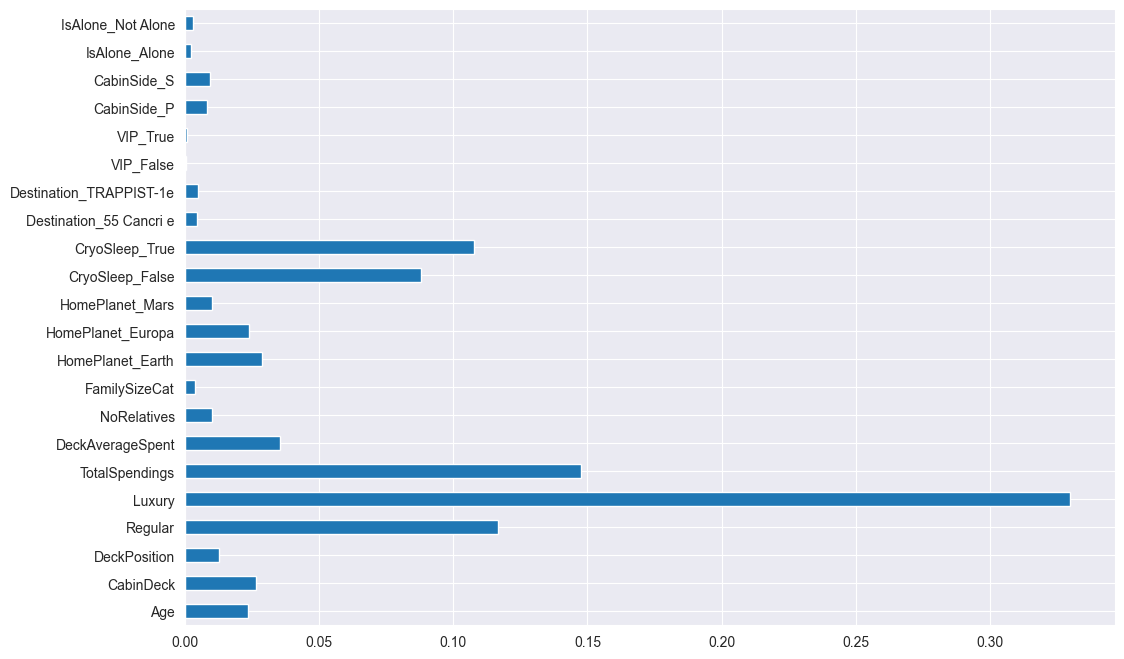

In [153]:
# plot feature importances
importances = pd.Series(model_final.feature_importances_, index = X.columns)
importances.plot(kind = 'barh', figsize = (12, 8))

<Axes: >

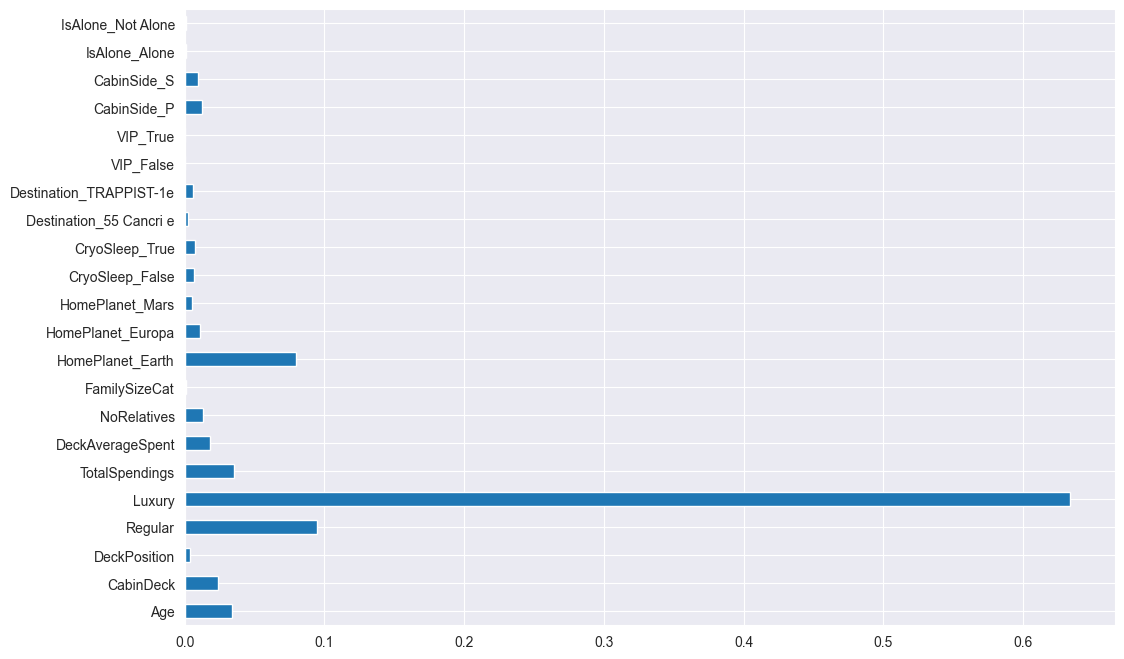

In [144]:
# plot feature importances
importances = pd.Series(best_gbmodel.feature_importances_, index = X.columns)
importances.plot(kind = 'barh', figsize = (12, 8))

<Axes: >

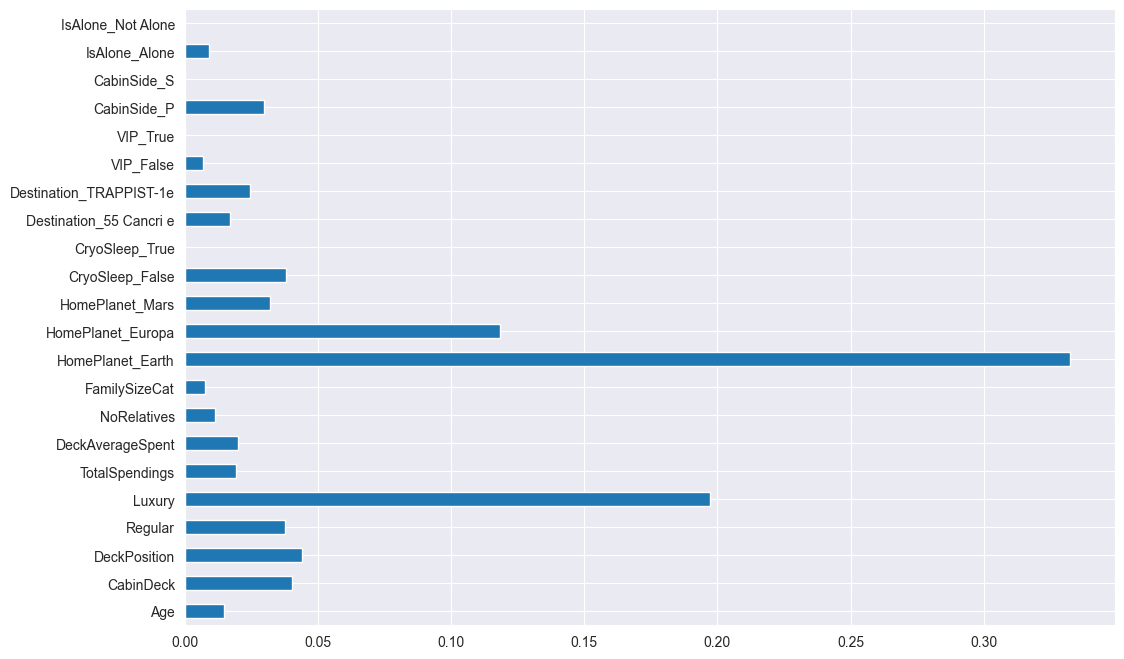

In [145]:
# plot feature importances
importances = pd.Series(best_xgb_classifier.feature_importances_, index = X.columns)
importances.plot(kind = 'barh', figsize = (12, 8))